<a href="https://colab.research.google.com/github/danih02/RAG-Pipeline-with-Google-OpenAI-Studio---Getting-recipes-from-German-Cookbook/blob/main/RAG_Pipeline_with_Google_OpenAI_Studio_Getting_recipes_from_German_Cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this workbook, we will consider a LangChain RAG to extract information out of a german cookbook - Das gute Essen: Mit 500 Rezepten für jeden Tag. We aim to extract specific information from this book like


1.   What recipe is on page x?
2.   Give me a recioe from the book containing Paprika.
3.   I have Paprika, eggs and cucumber in my fridge. Give me recipes where at least 2 of those ingridients are used.


The llm of consideration is a free tier from google OpenAI Studio - Gemini 1.5 Pro

# Install dependencies, get LLM and inspect docment

As already mentioned, we will use a LangChain pipeline.

In [1]:
%%capture
%pip install langchain pypdf faiss-cpu sentence-transformers transformers langchain-community langchain_google_genai

In [2]:
import pandas as pd
from langchain.document_loaders import PyPDFLoader # document loader for PDF
from langchain.text_splitter import RecursiveCharacterTextSplitter # text splitter
from langchain.embeddings import HuggingFaceEmbeddings # embedding model for FAISS
from langchain.vectorstores import FAISS # faiss retriever
from langchain.chains import RetrievalQA # LangChain RAG pipeline
from langchain.retrievers import BM25Retriever # BM25 retriever
from langchain.retrievers import EnsembleRetriever # ensemlbe retriever to combine FAISS and BM25

We are going to use a hybrid retriever: FAISS and BM25. In this setup, bm25 is possibly more useful that embedding queries. This is because recipes are of a more structured than semantic type and we will likely search for specific keywords like Paprika or Cucumber.

In [3]:
import os
os.chdir('/content/drive/MyDrive/_BOOK_Hands on Large Language Models/Documents/')
pdf_path = "Das gute Essen - Kochbuch.pdf"
loader = PyPDFLoader(pdf_path) # PyPDF load the documents pagewise
documents = loader.load()

PyPDFLoader loads the document page wise. This might be a problem for quering as on some pages of this book there are multiple recipes while for some pages there is a single recipe per page. We will already initilize the llm.

In [4]:
with open('/content/drive/My Drive/google_api_key.txt', 'r') as f: # get api key
    api_key = f.read().strip()

import google.generativeai as genai
genai.configure(api_key=api_key)

from langchain_google_genai import ChatGoogleGenerativeAI
os.environ["GOOGLE_API_KEY"] = api_key
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", streaming = True, temperature = 0) # gemini 1.5 pro lllm

In [5]:
from langchain import PromptTemplate

# create a prompt template with the "input_prompt" and "context" variables
template = """
{input_prompt}

Für deine Antwort, nutze nur folgenden Kontext:
{context}

Anworte strukturiert.

Gebe zuerst die Zutaten, dann die Vorgehensweise an und anschließend die Seite als Referenz an. Gebe nichts anderes außer dies an.

Falls sich in dem Kontext mehr als ein Rezept befindet, gebe alle an, außer es wird nur nach einem Rezept gefragt.


"""
prompt = PromptTemplate(template=template, input_variables=["input_prompt", "context"])

In [6]:
chain_example = prompt | llm

In [7]:
index_single_recipe = 17
index_multiple_recipes = 27

In [8]:
query = 'Erzähl mit etwas über das Rezept auf der Seite.'
context = documents[index_single_recipe].page_content
output = chain_example.invoke({'input_prompt' : query, 'context' : context}).content
print(output)

**Zutaten:**

* 1 Bund Vogelmiere (Wildkraut)
* 260 ml Geflügelbrühe
* 1,5 g Agar-Agar (pflanzliche Gelatine)
* 50 ml Sahne
* 1 Blatt Gelatine
* Salz, Pfeffer
* 10 Kartoffeln (La Ratte)
* 5 EL Olivenöl extra vergine
* 2 EL Rotweinessig
* 4 Scheiben rustikales Weißbrot
* 4 Knoblauchzehen
* 8 EL Tomatenkonfitüre mit Fenchel und Anis
* 2 Makrelen
* 100 ml Vinaigrette
* 12 Schalotten
* 2 EL Butter
* 20 g Risottoreis
* Weißer Balsamicoessig
* 2 Bund Brunnenkresse


**Vorgehensweise:**

1. **Vogelmierencreme:** Vogelmiere kochen, mixen, mit Agar-Agar, Sahne und Gelatine aufkochen, würzen und in Form gießen. Kühl stellen.
2. **Kartoffelsalat:** Kartoffeln kochen, pellen, in Scheiben schneiden und mit Olivenöl-Rotweinessig-Marinade marinieren.
3. **Brot:** Brotscheiben mit Knoblauch in Olivenöl braten, mit Tomatenkonfitüre bestreichen.
4. **Makrele:** Makrelen filetieren, in Streifen schneiden, anbraten, mit Vinaigrette übergießen. Einige Streifen für später beiseitelegen, Rest auf die Brotsch

and we do the same for the multiplce page document without changing the query.

In [9]:
query = 'Erzähl mit etwas über das Rezept auf der Seite.'
context = documents[index_multiple_recipes].page_content
output = chain_example.invoke({'input_prompt' : query, 'context' : context}).content
print(output)

**Winterlicher Fenchel-Orangen-Salat**

*Zutaten:*
2 Orangen
2 Fenchel
Parmesan nach Belieben
1 Handvoll entsteinte schwarze Oliven
2-3 EL milder Obstessig
4 EL neutrales Pflanzenöl
Salz, Pfeffer

*Zubereitung:*

1. Orangen schälen, weiße Haut entfernen, Filets herausschneiden und Saft auffangen.
2. Fenchel putzen, waschen und fein hobeln.
3. Parmesan fein hobeln.
4. Fenchel, Parmesan und Orangenfilets vermischen.
5. Oliven halbieren und zum Salat geben.
6. Aus Essig, Orangensaft, Öl, Salz und Pfeffer eine Salatsauce rühren.
7. Sauce über den Salat geben und vorsichtig vermischen.

*Seite:* 28


**Feldsalat mit Rote Bete**

*Zutaten:*
200g vakuumverpackte Rote Bete
200g Feldsalat
50g Walnüsse
5 EL Walnussöl
1 EL Rotweinessig
1 EL Balsamicoessig
Salz, Pfeffer

*Zubereitung:*

1. Rote Bete in 1 cm große Würfel schneiden.
2. Feldsalat verlesen, waschen und trocken schleudern.
3. Walnüsse klein schneiden.
4. Rote Bete, Feldsalat und Nüsse mischen.
5. Für die Vinaigrette Walnussöl mit Rotwe

Let us display the pdf pages to manually check how accurate our llm was:

In [10]:
# Install poppler and other needed packages to display images
%%capture
!apt-get install -y poppler-utils
!pip install pdf2image pillow

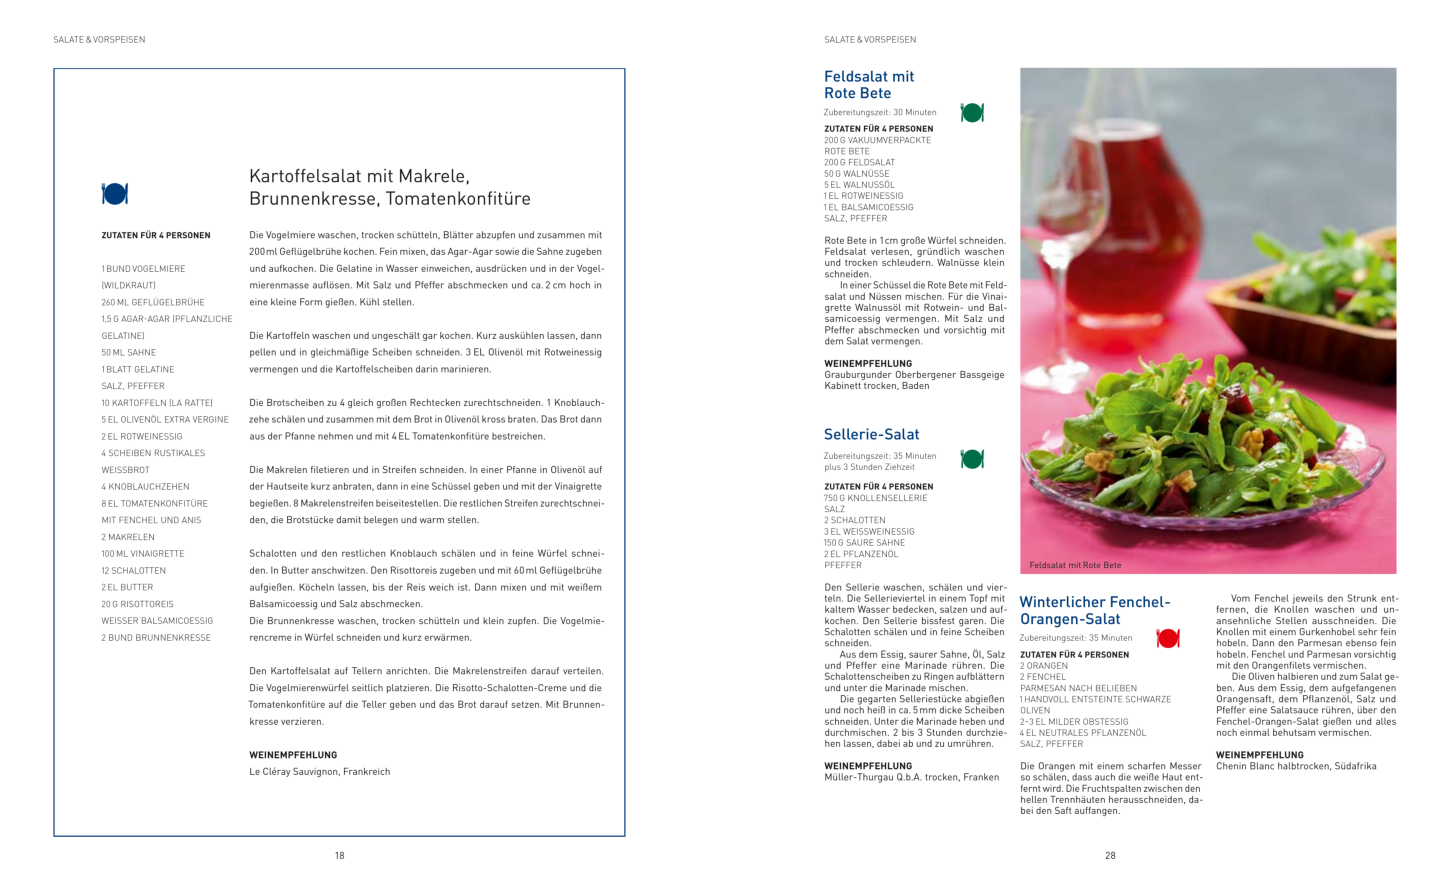

In [89]:
import pdf2image
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

# get pages
pages = convert_from_path("Das gute Essen - Kochbuch.pdf", first_page = 1, last_page = index_multiple_recipes + 1)

# restrict to our 2 examples indices
pages= [pages[index_single_recipe]] + [pages[index_multiple_recipes]]

fig, axes = plt.subplots(1, 2, figsize=(16, 9))
for ax, img in zip(axes, pages):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Comparing the llms output to the actual recipes, we see that it did a really good job for the first single recipe. For the multiple recipe page it worked just as good with extraction of every single recipe. This is due to the specific prompt that everything should be extracted.

# Splitting the Document

From the previous two examples we see that some pages can contain multiple recipes. This might cause problems: Imagine if we are asking for a mediteran dish. As we are not asking specific ingridients we can sear for, i.e., BM25 reader,  this resembles for an embedding type of problem. But it is very possible that on a single are not only mediteran dish, so embedding might not work.

So what we would want to have is the document split into recipes. We approach this problem in two steps.

1.   Classical text splitter like RecursiveTextSplitter do not split the text in reading order. So we need to split the pages text in our own way.
2.   Afterwards, we split each page containing multiple recipes into single chunks.



## Bringng pages into reading order

The easiest way to do this is to simply as an llm to do it. As we saw above, this works reasonable. However, Google's OpenAI Studio free tier cannot do this and I don't wont to pay for it.

The idea is the following: we split each page vertically into 3 parts of same width. In this way we are going to seperate recipes as above. For recipes on a single page this will not cause any troubles as the ingridients list and how to prepare it are written block-wise.

In [63]:
%%capture
%pip install pymupdf

In [77]:
import fitz  # PyMuPDF

pdf_path = "Das gute Essen - Kochbuch.pdf"
doc = fitz.open(pdf_path)

all_text_blocks = []

# save origin, i.e., (x,y) coordinates of lines, page_num and text into a dictionary
for page_num, page in enumerate(doc):
    blocks = page.get_text("dict")["blocks"]
    for block in blocks:
        if "lines" in block:
            for line in block["lines"]:
                for span in line["spans"]:
                    text = span["text"]
                    origin = span["origin"]
                    if text:
                        all_text_blocks.append({
                            "text": text,
                            "page": page_num + 1,
                            "origin" : origin
                        })

As an example we will print the index_single_recipe from all_text_blocks

In [79]:
all_text_blocks[100]

{'text': 'Dr. Cordes: Gutes Essen basiert auf guten, nachhaltig oder zumindest regional an\xad',
 'page': 5,
 'origin': (144.6280975341797, 622.48828125)}

In [86]:
for block in all_text_blocks:
    if block['page'] == index_single_recipe + 1:
        print(block['text']) # every text is a new line on the page

Salate & Vorspeisen
18
Kartoffelsalat mit Makrele,  
Brunnenkresse, Tomatenkonfitüre 
Die Vogelmiere waschen, trocken schütteln, Blätter abzupfen und zusammen mit 
200 ml Geflügelbrühe kochen. Fein mixen, das Agar-Agar sowie die Sahne zu­geben 
und aufkochen. Die Gelatine in Wasser ein­weichen, ausdrücken und in der Vogel-
mierenmasse auflösen. Mit Salz und Pfeffer abschmecken und ca. 2 cm hoch in 
eine kleine Form gießen. Kühl stellen.
Die Kartoffeln waschen und ungeschält gar kochen. Kurz auskühlen lassen, dann 
pellen und in gleichmäßige Scheiben schneiden. 3 EL Olivenöl mit Rotweinessig 
vermengen und die Kartoffelscheiben darin marinieren. 
Die Brotscheiben zu 4 gleich großen Rechtecken zurechtschneiden. 1 Knoblauch-
zehe schälen und zusammen mit dem Brot in Olivenöl kross braten. Das Brot dann 
aus der Pfanne nehmen und mit 4 EL Tomatenkonfitüre bestreichen.
Die Makrelen filetieren und in Streifen schneiden. In einer Pfanne in Olivenöl auf 
der Hautseite kurz anbraten, dann in ei

Even tought the ingridients list at the bottom, this will likely not cause a problem for the llm. To highlight the problem with multiples recipes consider the multiple recipes page. Plotting just the first we line we can already see the problem:

In [90]:
i = 0
for block in all_text_blocks:
    if block['page'] == index_multiple_recipes + 1:
        i += 1
        print(block['text']) # every text is a new line on the page
        if i == 5:
            break

Salate & Vorspeisen
28
Vom Fenchel jeweils den Strunk ent­
fernen, die Knollen waschen und un­
ansehnliche Stellen ausschneiden. Die 


Comparing with the picture above, the first lines are just some lines of the last recipe on the bottom right. But we want the recipes in logical reading order. We split the coordinates in 'origin' into x and y coordinates.

In [97]:
import pandas as pd
text = []
origin_x = []
origin_y = []
page = []
for block in all_text_blocks:
    text.append(block['text'])
    origin_x.append(block['origin'][0])
    origin_y.append(block['origin'][1])
    page.append(block['page'])

df = pd.DataFrame({'text' : text, 'origin_x' : origin_x, 'origin_y' : origin_y, 'page' : page})
df.head(5)

,text,origin_x,origin_y,page
0,MIT 500 REZEPTEN,200.801605,595.130798,1
1,FÜR JEDEN TAG,219.017609,622.270752,1
2,KOCHBUCH,200.891800,157.897400,1
3,2,298.123505,775.559265,2
4,Vorwort,39.586601,30.614380,2


Now we split each page into 3 parts 'left', 'middle' and 'right'. This is decided by the values of x and the width of the page. Note that the pages are all of the same size.

In [98]:
page = doc[0]
page_height = page.rect.height
page_width = page.rect.width
splitter_num = [page_width/3, page_width/2, page_width]
splitter_cat = ['left','middle','right']

In [101]:
# function which assign 'left', 'middle' or 'right on dataframe depending on origin_x value
def get_position(x):
    if 0 <= x <= splitter_num[0]:
        return splitter_cat[0]
    elif splitter_num[0] < x <= splitter_num[1]:
        return splitter_cat[1]
    elif splitter_num[1] < x <= splitter_num[2]:
        return splitter_cat[2]
    else:
        raise ValueError(f"x={x} is out of bounds for the defined splitter range.")

df['position'] = df['origin_x'].apply(get_position)

Let us test this on our multiple recipe page

In [52]:
dashed_line = "-" * 100 # create dashed line for structured output

In [105]:
for split in splitter_cat:
    print(f'Position: {split}\n')
    for text in df[(df['position'] == split) & (df['page'] == (index_multiple_recipes + 1))]['text']:
        print(text)
    print(dashed_line)

Position: left

Salate & Vorspeisen
Feldsalat mit 
Rote Bete
Zubereitungszeit: 30 Minuten
Zutaten für 4 Personen
200 g vakuumverpackte  
Rote Bete 
200 g Feldsalat 
50 g Walnüsse 
5 EL Walnussöl 
1 EL Rotweinessig 
1 EL Balsamicoessig 
Salz, Pfeffer 
Rote Bete in 1 cm große Würfel schneiden. 
Feldsalat verlesen, gründlich waschen 
und trocken schleudern. Walnüsse klein 
schneiden. 
In einer Schüssel die Rote Bete mit Feld- 
salat und Nüssen mischen. Für die Vinai-
grette Walnussöl mit Rotwein- und Bal­
samicoessig vermengen. Mit Salz und  
Pfeffer abschmecken und vorsichtig mit 
dem ­Salat vermengen. 
Weinempfehlung
Grauburgunder Oberbergener Bassgeige 
Kabinett trocken, Baden
Sellerie-Salat 
Zubereitungszeit: 35 Minuten  
plus 3 Stunden Ziehzeit
Zutaten für 4 Personen
750 g Knollensellerie 
Salz 
2 Schalotten 
3 EL WeiSSweinessig 
150 g saure Sahne 
2 EL Pflanzenöl 
Pfeffer 
Den Sellerie waschen, schälen und vier-
teln. Die Sellerie­viertel in einem Topf mit 
kaltem Wasser bedecken, s

We see that this workes quite well and the text is in a chronological order.